# Оценка автомл модели

In [1]:
# установка последнего lightautoml
# !pip install -q git+https://github.com/sb-ai-lab/LightAutoML.git
# !pip install shap

In [2]:
import os
if 'drive' not in os.listdir():
    from google.colab import drive
    drive.mount('/content/drive')

path_to_folder = '/content/drive/MyDrive/psb_hack'

In [3]:
# standard libraries
import sys
import os
import json
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# ds libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve,roc_auc_score,average_precision_score,auc
from sklearn.base import BaseEstimator
from sklearn.calibration import CalibratedClassifierCV,CalibrationDisplay,calibration_curve
from sklearn.model_selection import StratifiedGroupKFold
import torch
# lama
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
# save/load model
import joblib
import gc
import yaml
# свои функции по оценке метрик
path_to_model_utils = '/content/drive/MyDrive/psb_hack'
sys.path.append(os.path.join(path_to_model_utils,'model_utils'))
from model_estimation import *

### Загрузка конфига и данных

In [4]:
print("Доступные конфиги модели:\n")
sorted(filter(lambda x: 'lama' in x, os.listdir(os.path.join(path_to_folder, 'models'))))

Доступные конфиги модели:



['psb_hack_lama_v511.pkl',
 'psb_hack_lama_v521.pkl',
 'psb_hack_lama_v531.pkl',
 'psb_hack_lama_v532.pkl',
 'psb_hack_lama_v533.pkl',
 'psb_hack_lama_v541.pkl',
 'psb_hack_lama_v542.pkl',
 'psb_hack_lama_v543.pkl']

In [5]:
# конфиг модели
config_name = 'psb_hack_lama_v541.yaml'

In [6]:
# конфиг модели
with open(os.path.join(path_to_folder, 'configs', config_name),'r',encoding='utf-8') as config:
    config_model = yaml.full_load(config)
# нужные файлы
full_train_flag = config_model['full_train_flag']
features_pack = config_model['features_pack']
model_file =  os.path.join(path_to_folder,'models',config_model['model_name'] + '.pkl')
metric_file =  os.path.join(path_to_folder,'metrics',config_model['model_name'] + '_metrics.xlsx')

# Анализ моделей

### Загрузка моделей и данных

In [7]:
# чтение данных
dates = ['Дата бронирования','Дата отмены', 'Заезд', 'Выезд']
read_cols = None
train_full = pd.read_csv(os.path.join(path_to_folder,'data',f'full_train_{features_pack}.csv'),parse_dates=dates,
                         usecols=read_cols)
train = pd.read_csv(os.path.join(path_to_folder,'data',f'train_{features_pack}.csv'),parse_dates=dates,
                    usecols=read_cols)
oot_val = pd.read_csv(os.path.join(path_to_folder,'data',f'oot_val_{features_pack}.csv'),parse_dates=dates,
                      usecols=read_cols)
oof_val = pd.read_csv(os.path.join(path_to_folder,'data',f'oof_val_{features_pack}.csv'),parse_dates=dates,
                      usecols=read_cols)

train_data = train_full if full_train_flag else train
gc.collect()
# загрузим модель

with open(model_file,'rb') as save_model:
    model = joblib.load(save_model)
print(model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.29323 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.08642 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.33736 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.11513 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.11144 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) +
	 0.05642 * (5 averaged models Lvl_0_Pipe_1_Mod_5_Tuned_XGBoost) 


In [8]:
target = model.reader.target
train_pred = model.predict(train_data).data.reshape(-1)
print(f"Целевая метрика {config_model['task']['metric']} на train для {target}:", model.task.metric_func(train_data[target],train_pred))
oot_val_pred = model.predict(oot_val).data.reshape(-1)
print(f"Целевая метрика {config_model['task']['metric']} на oot для {target}:", model.task.metric_func(oot_val[target],oot_val_pred))
oof_val_pred = model.predict(oof_val).data.reshape(-1)
print(f"Целевая метрика {config_model['task']['metric']} на oof для {target}:", model.task.metric_func(oof_val[target],oof_val_pred))

Целевая метрика auc на train для target: 0.9264867599912046
Целевая метрика auc на oot для target: 0.8307178315341581
Целевая метрика auc на oof для target: 0.8372416643044328


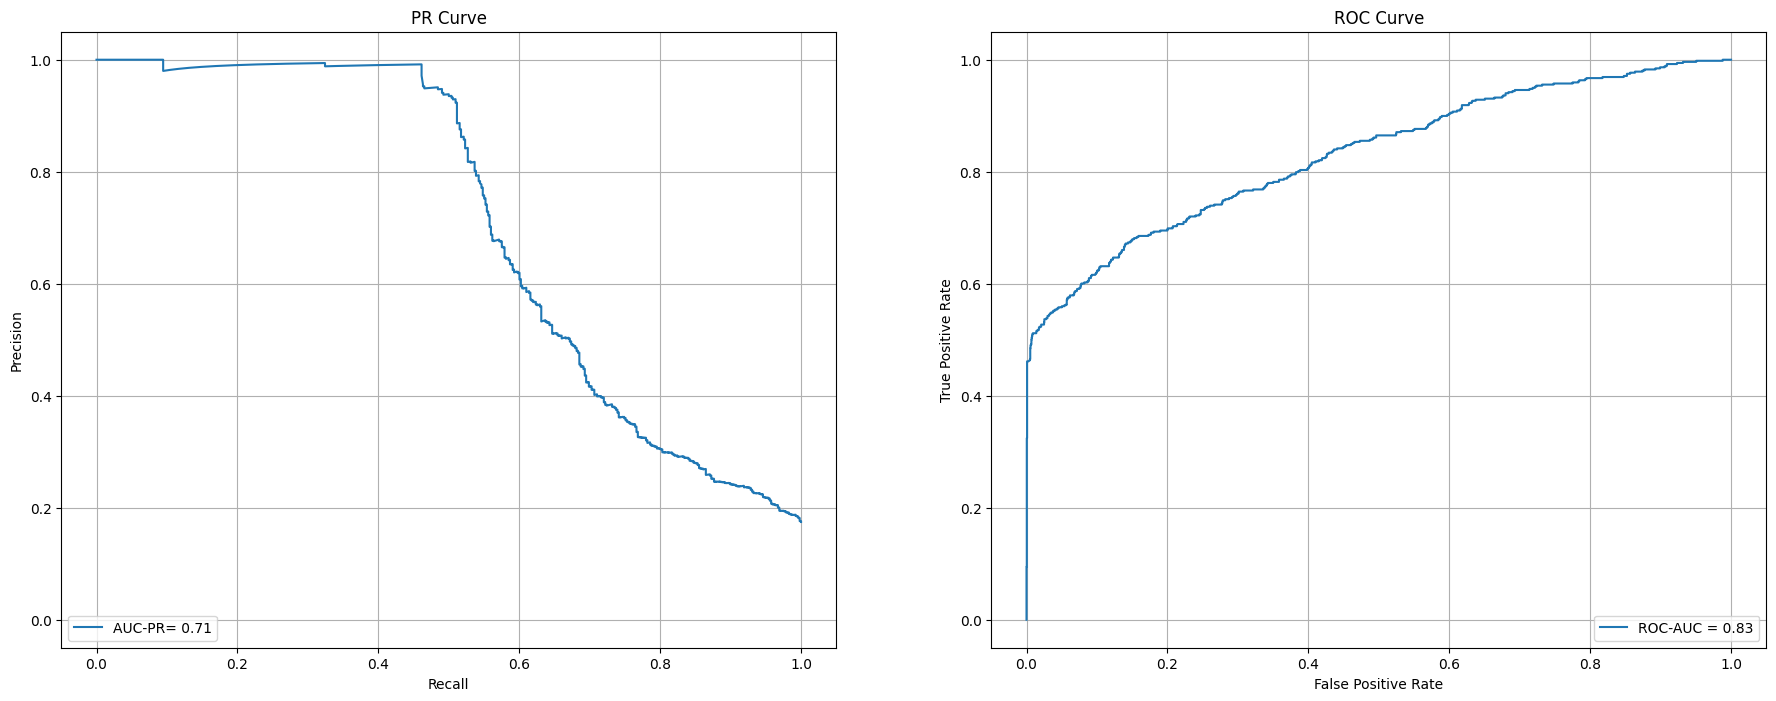

In [9]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


precision, recall, thresholds = precision_recall_curve(oot_val[target],oot_val_pred)
ap = auc(recall, precision)
ax1.plot(recall,precision, label = f'AUC-PR= {round(ap,2)}')

fpr, tpr, thresholds = roc_curve(oot_val[target],oot_val_pred)
rocauc = roc_auc_score(oot_val[target],oot_val_pred)
ax2.plot(fpr,tpr, label = f'ROC-AUC = {round(rocauc,2)}')

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
ax1.grid()
ax2.grid()
plt.show()

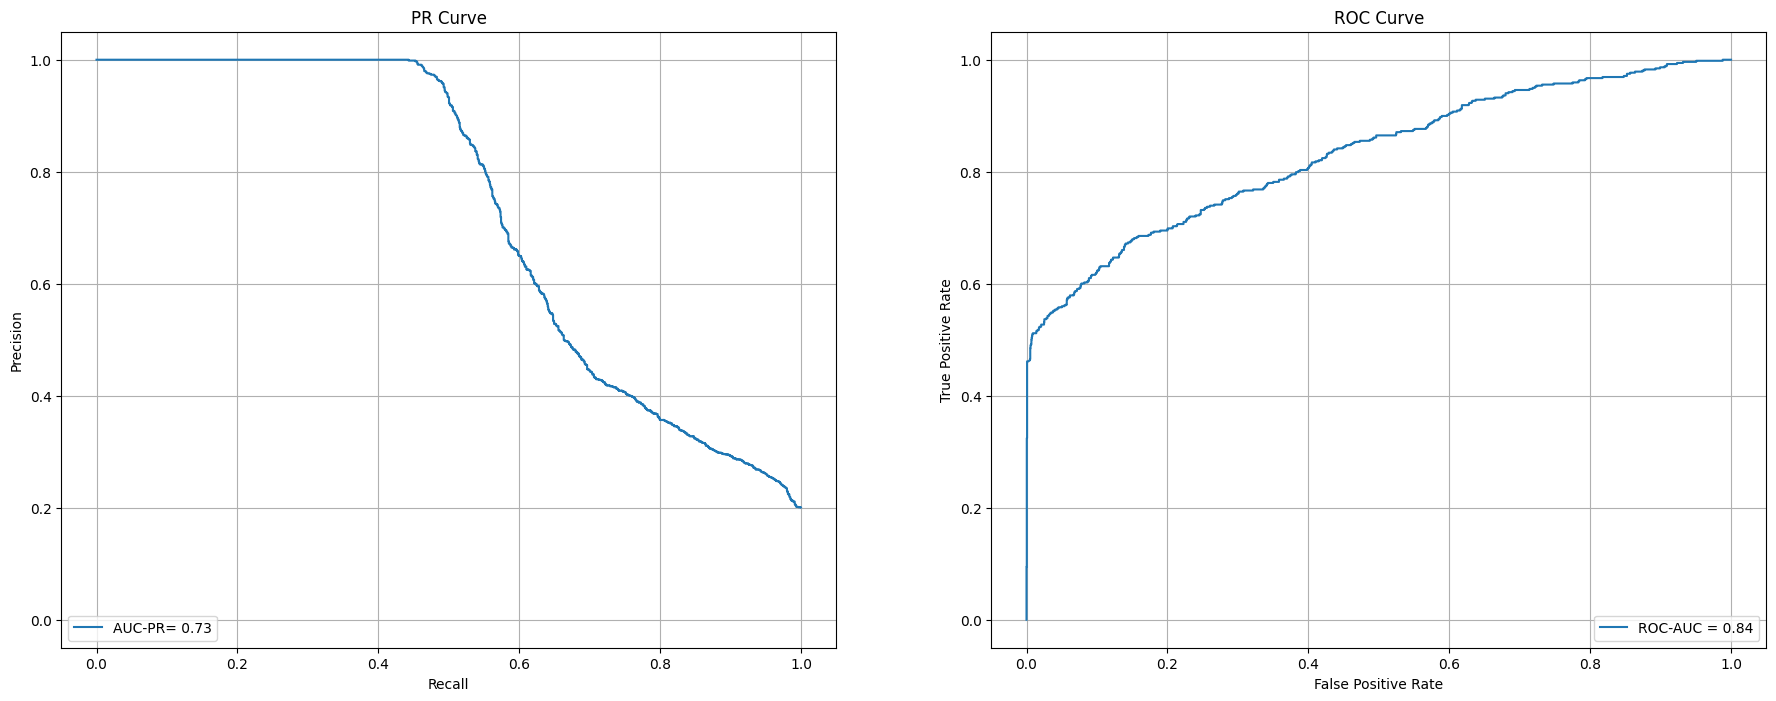

In [10]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

precision, recall, thresholds = precision_recall_curve(oof_val[target],oof_val_pred)
ap = auc(recall, precision)
ax1.plot(recall,precision, label = f'AUC-PR= {round(ap,2)}')

fpr, tpr, thresholds = roc_curve(oot_val[target],oot_val_pred)
rocauc = roc_auc_score(oof_val[target],oof_val_pred)
ax2.plot(fpr,tpr, label = f'ROC-AUC = {round(rocauc,2)}')

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
ax1.grid()
ax2.grid()
plt.show()

### Значимости фичей

In [11]:
# from lightautoml.addons.tabular_interpretation import SSWARM
# import shap
# explainer = SSWARM(model)
# sample = oot_val.groupby(target).sample(200)
# shap_values = explainer.shap_values(sample, n_jobs=8)\

# feats = []
# fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

# for i, feat in enumerate(feats):
#     shap.dependence_plot(feat, shap_values[1], sample[explainer.used_feats],
#                          show=False, ax=ax[i], interaction_index="EXT_SOURCE_1")

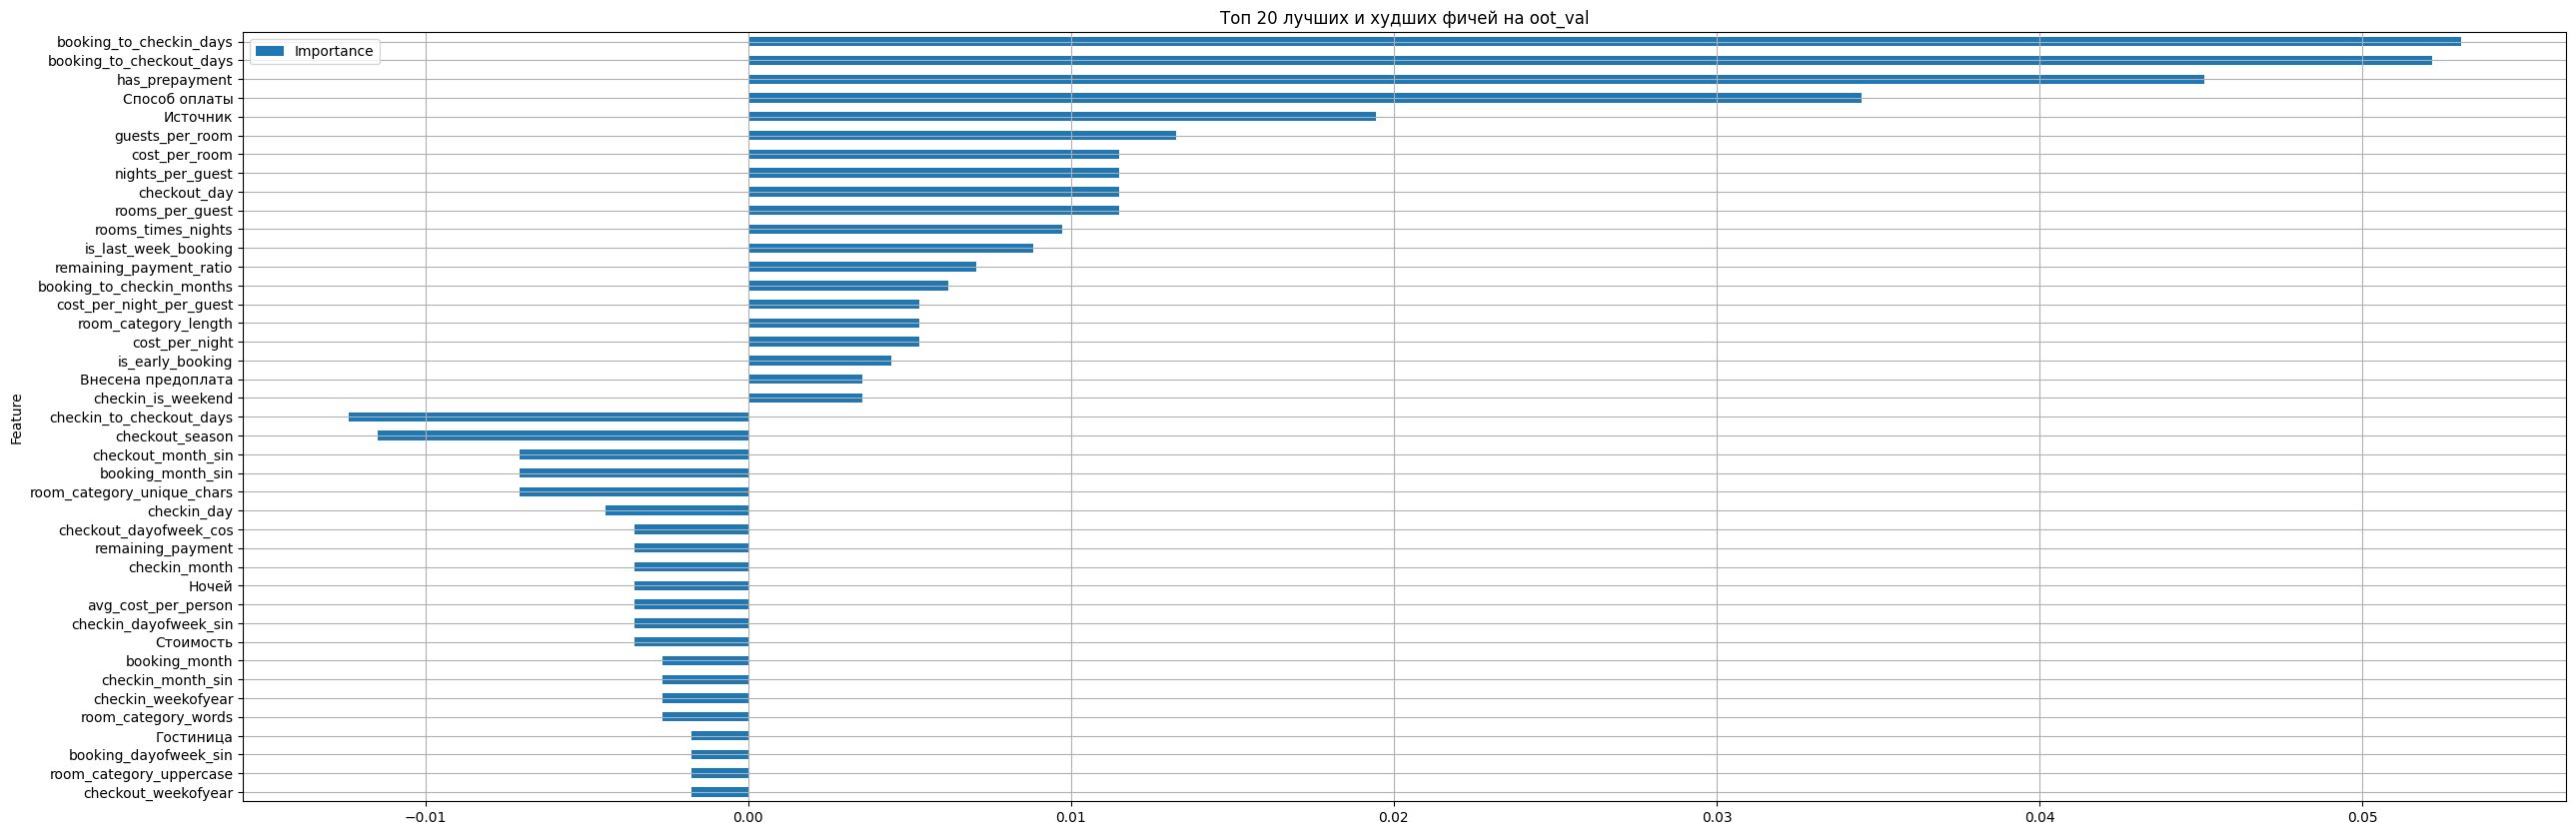

In [12]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_scores('accurate', oot_val[model.reader.used_features + [target]].sample(100), silent = False)
idx = list(range(20,-1,-1)) + list(range(-20,0))
feature_importance.set_index('Feature').sort_values(by='Importance',ascending = True).iloc[idx].plot.barh(grid=True,figsize=(30,10),
                                                                                        title = f"Топ 20 лучших и худших фичей на oot_val" )
plt.show()

### Подбор порога

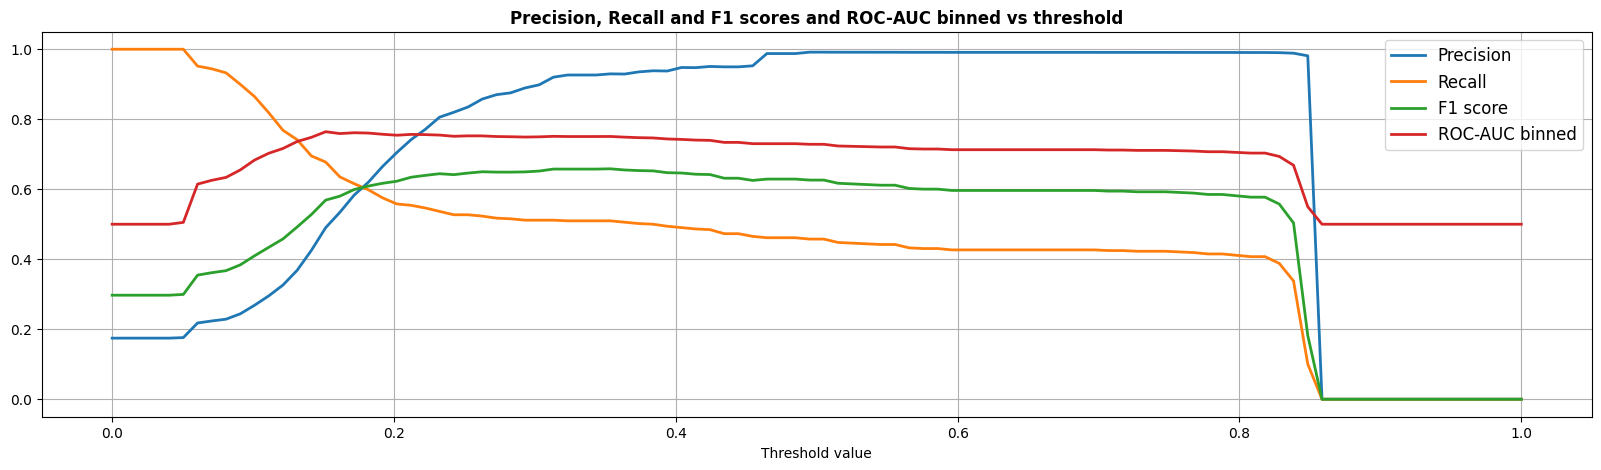

In [22]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)
ra = np.zeros_like(tr)

for k, x in enumerate(tr):
    p[k] = precision_score(oot_val[target],(oot_val_pred >= x).astype(int))
    r[k] = recall_score(oot_val[target],(oot_val_pred >= x).astype(int))
    f[k] = f1_score(oot_val[target],(oot_val_pred >= x).astype(int))
    ra[k] = roc_auc_score(oot_val[target],(oot_val_pred >= x).astype(int))

best_thr = tr[np.argmax(f)]

fig = plt.figure(figsize=(20, 5))

plt.plot(tr, p, linewidth=2)
plt.plot(tr, r, linewidth=2)
plt.plot(tr, f, linewidth=2)
plt.plot(tr, ra, linewidth=2)

plt.title("Precision, Recall and F1 scores and ROC-AUC binned vs threshold", weight="bold")
plt.xlabel("Threshold value")
plt.legend(['Precision', 'Recall', 'F1 score','ROC-AUC binned'], fontsize=12)
plt.grid()
plt.show()

### Метрики

In [23]:
result_dict = {}

### Метрики на train

In [24]:
overall_metrics = model_metric_perfomance(model, train_data,**{'threshold' : best_thr})
result_dict['train'] = {'overall' : overall_metrics}

for bin_col in ['region','Источник','has_prepayment']:
    bin_filter = train_data[bin_col].value_counts().index.tolist()[:5]
    bin_metric = model_metric_perfomance_on_bins(model, train_data.loc[train_data[bin_col].isin(bin_filter)],
                                                 bin_col=bin_col, **{'threshold' : best_thr})

    result_dict['train'].update(bin_metric)

### Метрики на val oot

In [25]:
overall_metrics = model_metric_perfomance(model, oot_val,**{'threshold' : best_thr})
result_dict['oot_val'] = {'overall' : overall_metrics}

for bin_col in ['region','Источник','has_prepayment']:
    bin_filter = train_data[bin_col].value_counts().index.tolist()[:5]
    bin_metric = model_metric_perfomance_on_bins(model, oot_val.loc[oot_val[bin_col].isin(bin_filter)],
                                                 bin_col=bin_col, **{'threshold' : best_thr})
    result_dict['oot_val'].update(bin_metric)

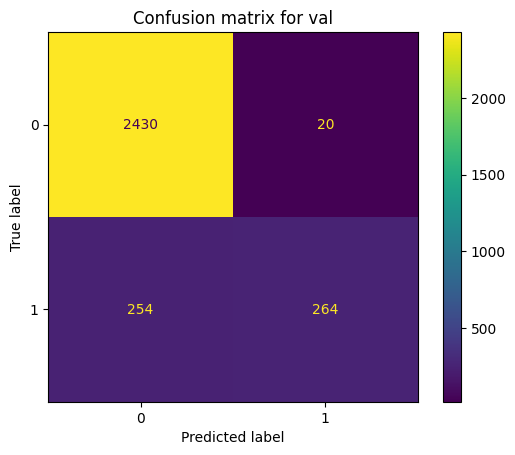

In [26]:
classes = [0,1]
predictions = (oot_val_pred >= best_thr).astype(int)
cm = confusion_matrix(oot_val[target], predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)
disp.plot()
plt.title('Confusion matrix for val')
plt.show()

### Метрики на val oof

In [27]:
overall_metrics = model_metric_perfomance(model, oof_val,**{'threshold' : best_thr})
result_dict['oof_val'] = {'overall' : overall_metrics}

for bin_col in ['region','Источник','has_prepayment']:
    bin_filter = train_data[bin_col].value_counts().index.tolist()[:5]
    bin_metric = model_metric_perfomance_on_bins(model, oof_val.loc[oof_val[bin_col].isin(bin_filter)],
                                                 bin_col=bin_col, **{'threshold' : best_thr})
    result_dict['oof_val'].update(bin_metric)

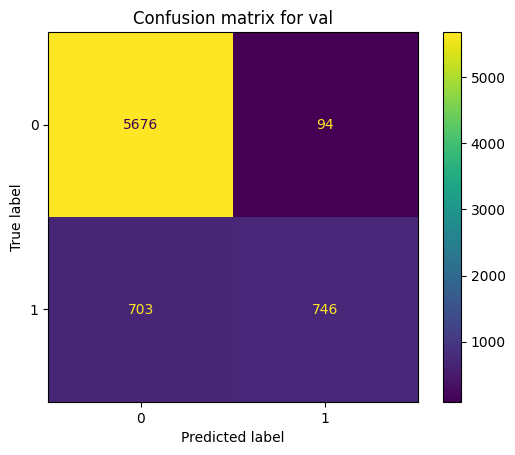

In [28]:
classes = [0,1]
predictions = (oof_val_pred >= best_thr).astype(int)
cm = confusion_matrix(oof_val[target], predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)
disp.plot()
plt.title('Confusion matrix for val')
plt.show()

### Перевод метрик в удоную таблицу

In [29]:
result_df = []

for k,v in result_dict.items():
    for k_,v_ in v.items():
        k_ = k_.split('with bin =')
        if len(k_) > 1:
            res = {'dataset': k, 'target' : config_model['roles']['target'], 'group' : k_[0].strip(), 'measurement' : k_[-1].strip()}
        else:
            res = {'dataset': k, 'target' : config_model['roles']['target'], 'group' : k_[0].strip(), 'measurement' : None}

        res.update(v_)
        result_df.append(res)

result_df = pd.DataFrame(result_df)
result_df.to_excel(metric_file,index=False)

In [30]:
result_df.loc[result_df.group == 'overall',['dataset', 'target',	'group', 'measurement', 'N','roc-auc original','roc-auc_hack','precision']]

,dataset,target,group,measurement,N,roc-auc original,roc-auc_hack,precision
0,train,target,overall,None,15987,0.926487,0.783621,0.927897
10,oot_val,target,overall,None,2968,0.830718,0.750745,0.929577
20,oof_val,target,overall,None,7219,0.837242,0.749273,0.888095
